In [49]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import insituFuncs as iF

import funcs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [5]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
print(h_const)

0.6774


# where is tracer parent?

find out, where the tracer parent sits, i.e. whether it's still in the main progenitor or in another galaxy or in the IGM

In [35]:
def location_of_parents(parent_index_filename, basePath, start_snap, target_snap,\
                        useArrays = False, parent_indices = None, tracersInParentsOffsets = None):
    """first output returns the subhalo index if the tracer parent particle sits in a galaxy or -1 if it's in the IGM
    second output states, whether parent particle is inside main progenitor at target snapshot"""
    start = time.time()
    #load file
    if not useArrays:
        index_file = h5py.File(parent_index_filename,'r')
        parent_indices = index_file['parent_indices'][:,:]
        tracersInParentsOffsets = index_file['tracers_in_parents_offset'][:].copy()
        index_file.close()
    
    location = np.empty(parent_indices[:,0].shape,dtype=int)
    location.fill(-1) #by default every parent is in the IGM
    
    f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(target_snap) + '.hdf5','r')
    starsInSubOffset_target_snap = f['Subhalo/SnapByType'][:,4]
    gasInSubOffset_target_snap = f['Subhalo/SnapByType'][:,0]
    f.close()
    
    
    #load number of particles per galaxy to avoid classifying parents as bound to a galaxy 
    #while they're in reality "inner fuzz"
    #of a halo
    numInSub_target_snap = il.groupcat.loadSubhalos(basePath, target_snap, fields = ['SubhaloLenType'])
    gasNumInSub_target_snap = numInSub_target_snap[:,0].copy()
    starNumInSub_target_snap = numInSub_target_snap[:,4].copy()
    del numInSub_target_snap
    
    end_load = time.time()
    #print('time for loading: ',end_load-start)
    
    #find parent index in offset files in NlogM
    which = parent_indices[:,1]
    indices = parent_indices[:,0]     
    for i in nb.prange(parent_indices[:,0].shape[0]):
        if which[i] == 0: #gas parent
            ind = np.searchsorted(gasInSubOffset_target_snap,indices[i],'right')
            ind-=1 #compensate for how np.searchsorted chooses the index
            
            #only important for last galaxy of halo: check whether particle is inner fuzz, i.e. IGM particles
            if gasInSubOffset_target_snap[ind] + gasNumInSub_target_snap[ind] < indices[i]:
                continue
            
        else: #star parent
            ind = np.searchsorted(starsInSubOffset_target_snap,indices[i],'right')
            ind-=1 #compensate for how np.searchsorted chooses the index
            
            #only important for last galaxy of halo: check whether particle is inner fuzz, i.e. IGM particles
            if starsInSubOffset_target_snap[ind] + starNumInSub_target_snap[ind] < indices[i]:
                continue
                
        location[i]=ind
    
    end_loc = time.time()
    #print('time for locating: ',end_loc - end_load)
    
    #now identify parents that are still in their (main progenitor) galaxy
    
    ##################################insitu offsets AT START SNAPSHOT correctly##################################
    g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
    starsInSubOffset_start_snap = g['Subhalo/SnapByType'][:,4]
    g.close()
    numStarsInSubs_start_snap = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloLenType'])[:,4]
    
    #calculate _inSitu_ star offsets again
    check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
    insitu = check['InSitu'][:] #1 if star is formed insitu and 0 otherwise
    check.close()
    
    insituStarsInSubOffset = np.zeros(starsInSubOffset_start_snap.shape[0])
    for i in range(1,starsInSubOffset_start_snap.shape[0]):
        star_indices = np.arange(starsInSubOffset_start_snap[i-1],starsInSubOffset_start_snap[i-1] +\
                                 numStarsInSubs_start_snap[i-1])
        insitu_indices = insitu[star_indices]
        insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
    
    insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)
    
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,tracersInParentsOffsets).astype(int)
    
    parentsInSubOffset = np.insert(parentsInSubOffset,0,0)
    ######################################################################################################
    
    end_insitu = time.time()
    #print('time for insitu offsets: ',end_insitu - end_loc)
    
    numSubs_start_snap = il.groupcat.loadSubhalos(basePath,start_snap,fields=['SubhaloPos']).shape[0]
    ids = np.arange(numSubs_start_snap)

    #load all MPBs
    tree_ids = loadMPBs(basePath,start_snap,ids=ids, fields=['SubfindID'])
    end_loadMPBs = time.time()
    #print('time for loading MPBs: ',end_loadMPBs - end_loc)
    
    isInMP = np.empty(parent_indices[:,0].shape,dtype=bool)
    isInMP.fill(False)
    tree_check = list(tree_ids)
    
    #determine missing trees:
    missing = []
    counter = 0
    for i in range(parentsInSubOffset.shape[0]-1):
        if i != tree_check[counter]:
            missing.append(i)
            i+=1
            continue
        counter+=1
        
    end_check = time.time()        
    #print('time for checking trees: ',end_check - end_loadMPBs)
    
    test = 0
    for j in nb.prange(0,parentsInSubOffset.shape[0]-1): #loop over all galaxies at z=0
        #find all associated particles:
        parentIndicesInSub = np.arange(parentsInSubOffset[j],parentsInSubOffset[j+1])
        
        if j in missing or parentIndicesInSub.size == 0: #if subhalo hast no tree, skip it and assign "False"
            if j in missing:
                test+=parentIndicesInSub.size
            continue
        if tree_ids[j]['SubfindID'].shape[0] <= start_snap - target_snap: #if tree doesn't reach until target_snap
            test+=parentIndicesInSub.size            
            continue
        main_prog = tree_ids[j]['SubfindID'][start_snap - target_snap]
        where = np.where(location[parentIndicesInSub] == main_prog)[0] + parentIndicesInSub[0]
        isInMP[where] = True
        
    end = time.time()
    #print('time for checking MPs: ',end - end_check)
    #print('total time: ',end-start)
    #print('problems: ',test)
    return location, isInMP, parentsInSubOffset

In [9]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
location, isInMP, parentsInSubOffset = location_of_parents('files/TNG50-4/parent_indices_redshift_0.0.hdf5',\
                                       basePath, start_snap = 99, target_snap = 99)

0.0 ,  0


In [189]:
print(np.where(isInMP==True)[0].shape) #all insitu stars should be in their MP at z=0
print(np.where(isInMP==False)[0].shape)
print(np.where(location==-1)[0].shape) #no insitu star can be outside of its galaxy at z=0 -> result correct
print(np.where(location!=-1)[0].shape)

(274847,)
(693,)
(0,)
(275540,)


In [11]:
z4 = np.array([0,0.2,0.5,0.7,1.0,2.0,3.0,4.0,5.0])
snap4 = np.array([99,84,67,59,50,33,25,21,17])
z3 = np.array([0.2,0.5,1.0,2.0,3.0])
snap3 = np.array([84,67,50,33,25])

In [52]:
def fracs_w_mass_bins(basePath):
    snap = np.arange(99,1,-1)
    problem = []
    f = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
    for i in range(99,1,-1):
        if not f.__contains__(f'snap_0{i}'):
            problem.append(99-i)
    f.close()
    snap = np.delete(snap,problem)
    n = snap.size
    
    z = np.zeros(n)
    
    mp = np.zeros(n)
    igm = np.zeros(n)
    sub = np.zeros(n)
    total = np.zeros(n)

    nums = np.zeros((n,5,3))

    for i in range(n):
        f = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
        parent_indices = f[f'snap_0{snap[i]}/parent_indices'][:,:]
        offset = f[f'snap_0{snap[i]}/tracers_in_parents_offset'][:]
        f.close()
        
        #run function to determine location of parents
        location, isInMP, parentsInSubOffset =\
        location_of_parents('files/' + basePath[32:39] + '/all_parent_indices.hdf5', basePath, start_snap = 99,\
                            target_snap = snap[i], useArrays=True, parent_indices=parent_indices,\
                            tracersInParentsOffsets=offset)

        #load stellar masses
        sub_masses = il.groupcat.loadSubhalos(basePath,snap[i],fields=['SubhaloMassType'])[:,4] * 1e10/h_const

        #create mass bins
        mass_bin1 = np.where(np.logical_and(sub_masses != 0, sub_masses < 1e9))[0]
        mass_bin2 = np.where(np.logical_and(sub_masses >= 1e9, sub_masses < 1e10))[0]
        mass_bin3 = np.where(np.logical_and(sub_masses >= 1e10, sub_masses < 1e11))[0]
        mass_bin4 = np.where(np.logical_and(sub_masses >= 1e11, sub_masses < 1e12))[0]
        mass_bin5 = np.where(sub_masses >= 1e12)[0]
        
        #iterate over all galaxies to add numbers to mass bins
        for k in range(5):
            for j in locals()["mass_bin" + str(k + 1)]:
                indices = np.where(location == j)[0]
                nums[i,k,0] += np.where(isInMP[indices] == True)[0].shape[0] #mp in mass bin
                nums[i,k,1] += indices.shape[0] #other glalaxies in mass bin
                nums[i,k,2] += sum(nums[i,k,:2]) #total in mass bin
            nums[i,k,1] -= nums[i,k,0] #subtract number of parents in mp from number in other galaxies
                
        mp[i] = sum(nums[i,:,0])
        igm[i] = np.where(location == -1)[0].shape[0]
        sub[i] = np.where(location != -1)[0].shape[0]
        z[i] = il.groupcat.loadHeader(basePath,snap[i])['Redshift'] 
        total[i] = igm[i] + sub[i]       
        
    return mp, igm, sub, total, nums, z

In [ ]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-3/output'
mp, igm, sub, total, nums, z = fracs_w_mass_bins(basePath)

Text(0.5, 1.0, 'tracer fraction in MP / other galaxies / IGM')

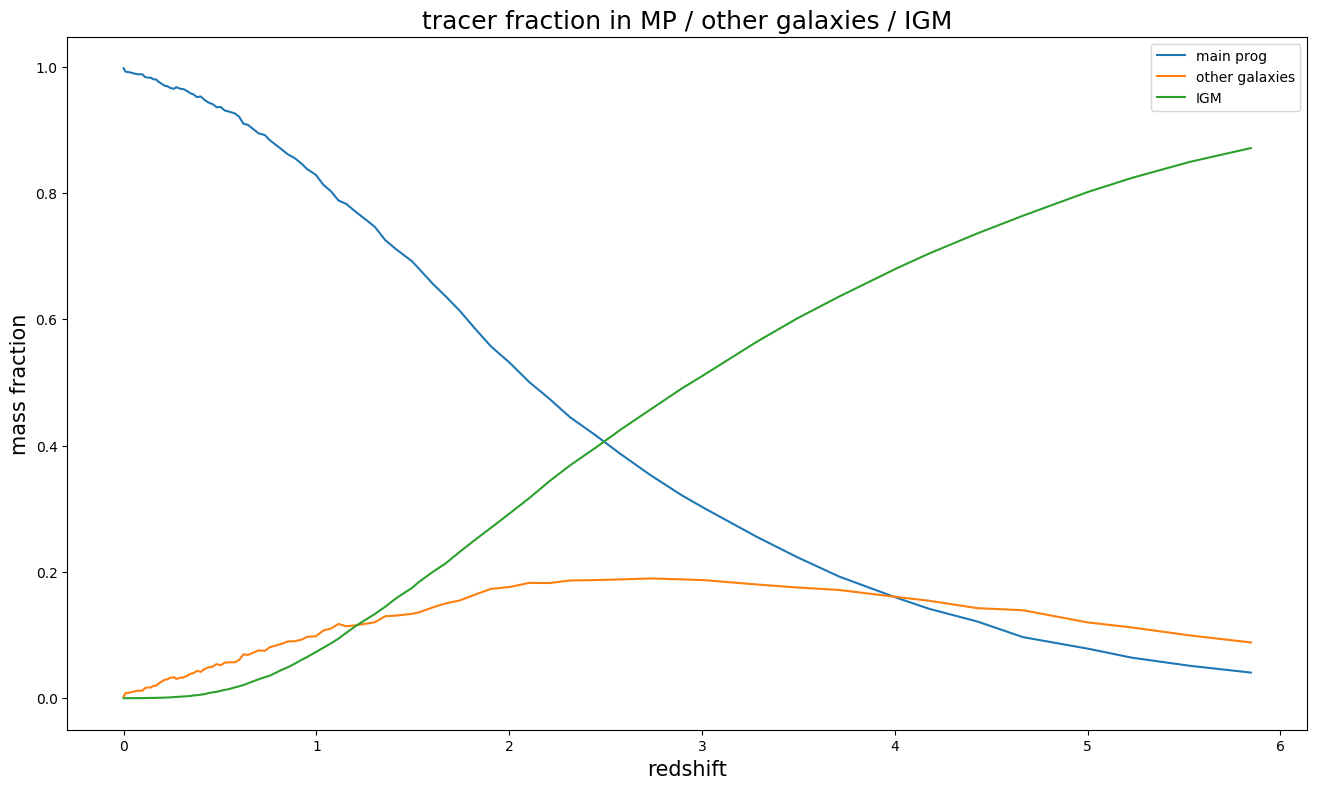

In [54]:
plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, label = 'IGM')
plt.legend()
plt.ylabel('mass fraction',size=15)
plt.xlabel('redshift',size=15)
#plt.xticks(z)
plt.title('tracer fraction in MP / other galaxies / IGM',size=18)
#plt.savefig('pics/tracer_fraction_TNG50-4.jpg',format='jpg')

In [56]:
print(nums[:,0,0])

[10402. 10459. 10477. 10571. 10466. 10516. 10623. 10617. 10582. 10669.
 10658. 10720. 10791. 10865. 10886. 11010. 11093. 11162. 11189. 11247.
 11258. 11432. 11427. 11522. 11746. 11720. 11895. 11976. 12033. 12187.
 12313. 12467. 12481. 12510. 12662. 13089. 13096. 13484. 13603. 13562.
 13850. 14175. 14388. 14525. 14750. 14854. 14920. 15195. 15693. 15819.
 15822. 16393. 16644. 16732. 17405. 17878. 18583. 19281. 19392. 20435.
 20296. 20588. 20827. 20694. 21402. 20909. 21043. 20848. 20686. 20204.
 20140. 20232. 19535. 19350. 18594. 17924. 17418. 16862. 16289. 15378.
 13829. 11364. 10240.  9010.  7554.  6442.]


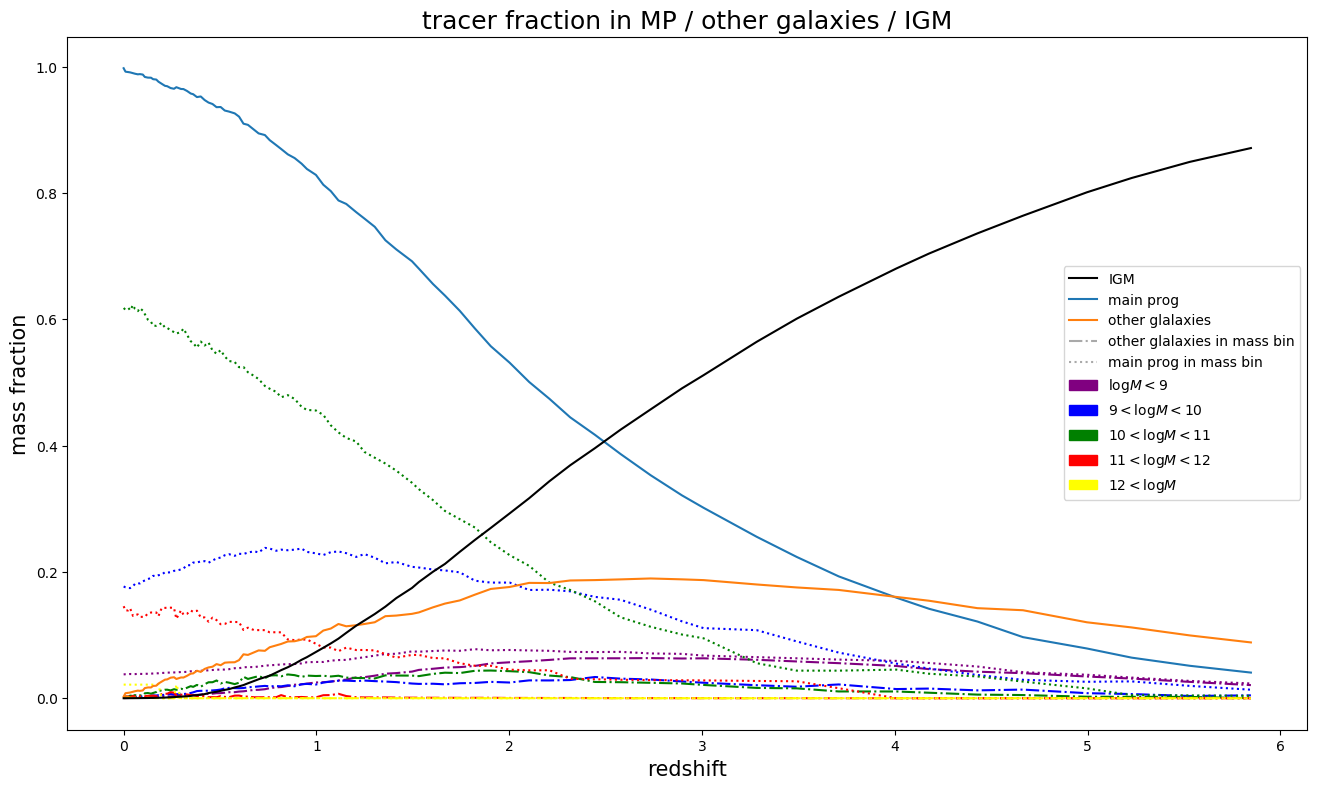

In [59]:
plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, color='black', label = 'IGM')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other glalaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other glalaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M}$')

plt.legend(handles=[IGM,MP,OTHER,dash,dotted,purple,blue,green,red,yellow])
plt.ylabel('mass fraction',size=15)
plt.xlabel('redshift',size=15)
#plt.xticks(z)
plt.title('tracer fraction in MP / other galaxies / IGM',size=18)
#plt.savefig('pics/tracer_fraction_TNG50-4_everything.jpg',format='jpg')